Macarena Benjamin

1) A partir de la siguiente información de LECAPs cotizantes en el mercado de valores argentino al 30/04/2025
se solicita ajuste y calibre adecuadamente los modelos de Nelson-Siegel y Nelson-Siegel-Svensson,
generando una curva de tasas que tenga los nodos propuestos debajo. ¿Es posible sobre los mismos datos
estimar un modelo utilizando regresión logarítmica? En tal caso, cual de los 3 modelos cree usted que
genera un mejor ajuste y estimaciones, justifique adecuadamente su respuesta. Analice los resultados
obtenidos

2) A partir de la información histórica de curvas de tasas que usted considere, se solicita calibre el modelo CIR,
generando 10.000 simulaciones con un horizonte temporal de 30 días y pasos de 1 día.

# Ejercicio 1

## **Importacion de los datos del enunciado**

In [ ]:
# Librerias
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Datos de LECAPs
lecaps_data = {
    "Ticker": ["S16Y5", "S30Y5", "S18J5", "S30J5", "S31L5", "S15G5", "S29G5", "S12S5", "S30S5", "T17O5",
               "S31O5", "S10N5", "S28N5", "T15D5", "T30E6", "T13F6", "T30J6", "T15E7"],
    "Vencimiento": ["16/05/25", "30/05/25", "18/06/25", "30/06/25", "31/07/25", "15/08/25", "29/08/25",
                     "12/09/25", "30/09/25", "15/10/25", "31/10/25", "10/11/25", "28/11/25", "15/12/25",
                     "30/01/26", "13/02/26", "30/06/26", "15/01/27"],
    "Dias": [11, 25, 44, 56, 87, 102, 116, 130, 148, 163, 179, 189, 207, 224, 270, 284, 421, 620],
    "TNA": [0.2888, 0.2934, 0.2994, 0.2882, 0.3049, 0.3285, 0.3235, 0.3246, 0.3237, 0.3321,
            0.3315, 0.3374, 0.3266, 0.3448, 0.3496, 0.3592, 0.3670, 0.3616]
}

lecaps_df = pd.DataFrame(lecaps_data)

# Nodos estándar
nodos_estandar_data = {
    "Nodo": [1, 30, 60, 90, 180, 270, 360, 720, 1080, 1440, 1800, 2520, 3600, 5400],
    "Nodo_Anios": [0.00278, 0.08333, 0.16667, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 10, 15]
}

nodos_estandar_df = pd.DataFrame(nodos_estandar_data)

In [ ]:
# Se verifica
lecaps_df

,Ticker,Vencimiento,Dias,TNA
0,S16Y5,16/05/25,11,0.2888
1,S30Y5,30/05/25,25,0.2934
2,S18J5,18/06/25,44,0.2994
3,S30J5,30/06/25,56,0.2882
4,S31L5,31/07/25,87,0.3049
5,S15G5,15/08/25,102,0.3285
6,S29G5,29/08/25,116,0.3235
7,S12S5,12/09/25,130,0.3246
8,S30S5,30/09/25,148,0.3237
9,T17O5,15/10/25,163,0.3321


In [ ]:
# Se verfica
nodos_estandar_df

,Nodo,Nodo_Anios
0,1,0.00278
1,30,0.08333
2,60,0.16667
3,90,0.25000
4,180,0.50000
5,270,0.75000
6,360,1.00000
7,720,2.00000
8,1080,3.00000
9,1440,4.00000


##**Nelson-Siegel y Nelson-Siegel-Svensson**

In [ ]:
# Funciones para el modelo
def nelson_siegel(params, tau, maturities):
    beta0, beta1, beta2, lambda_ = params
    return beta0 + (beta1 + beta2) * (1 - np.exp(-maturities / lambda_)) / (maturities / lambda_) - beta2 * np.exp(
        -maturities / lambda_)

def nelson_siegel_svensson(params, tau, maturities):
    beta0, beta1, beta2, beta3, lambda1, lambda2 = params
    term1 = (1 - np.exp(-maturities / lambda1)) / (maturities / lambda1)
    term2 = term1 - np.exp(-maturities / lambda1)
    term3 = (1 - np.exp(-maturities / lambda2)) / (maturities / lambda2) - np.exp(-maturities / lambda2)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# Función objetivo para optimización
def objective_function(params, model_func, tau, maturities, rates):
    predicted_rates = model_func(params, tau, maturities)
    return np.sum((predicted_rates - rates) ** 2)

# Calibración de los modelos
# Nelson-Siegel
initial_guess_ns = [0.1, -0.05, -0.05, 1]  # Iniciacion de los parametros (podria probarse con otros tambien)
result_ns = minimize(objective_function, initial_guess_ns, args=(nelson_siegel, 1, lecaps_df["Dias"].values, lecaps_df["TNA"].values),
                     method='L-BFGS-B')
params_ns = result_ns.x

# Nelson-Siegel-Svensson
initial_guess_nss = [0.1, -0.05, -0.05, 0.01, 1, 1]  # Iniciacion de los parametros (podria probarse con otros tambien)
result_nss = minimize(objective_function, initial_guess_nss, args=(nelson_siegel_svensson, 1, lecaps_df["Dias"].values, lecaps_df["TNA"].values),
                      method='L-BFGS-B')
params_nss = result_nss.x

# Generar curva de tasas para los nodos estándar
nodos_dias = nodos_estandar_df["Nodo"].values
tasas_ns = nelson_siegel(params_ns, 1, nodos_dias)
tasas_nss = nelson_siegel_svensson(params_nss, 1, nodos_dias)

## **Regresion Logaritmica**

In [ ]:
# Regresión Logarítmica
from scipy.optimize import curve_fit

def log_regression(x, a, b):
    return a * np.log(x) + b

# Usar días como variable independiente y TNA como variable dependiente
popt_log, pcov_log = curve_fit(log_regression, lecaps_df["Dias"].values, lecaps_df["TNA"].values)
a_log, b_log = popt_log

# Generar tasas estimadas con regresión logarítmica para los nodos estándar
tasas_log_regression = log_regression(nodos_estandar_df["Nodo"].values, a_log, b_log)

## **Resultados**

Parámetros Nelson-Siegel: [ 0.33769087 -0.34045534 -0.34044537  1.12249739]
Parámetros Nelson-Siegel-Svensson: [ 0.33768967 -0.25817345 -0.25817246 -0.19481619  1.09032565  1.03285755]
Parámetros Regresión Logarítmica: 0.022711755747281327 0.21700524749718514
MSE Nelson-Siegel: 0.0003160158445712355
MSE Nelson-Siegel-Svensson: 0.00031602688555462986
MSE Regresión Logarítmica: 8.735299080829816e-05


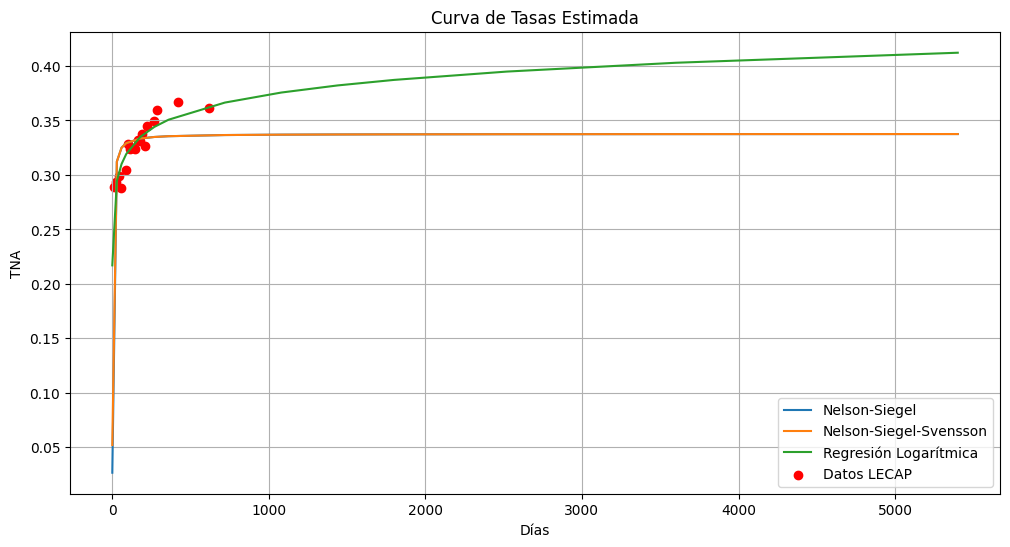

In [ ]:
# Resultados
print("Parámetros Nelson-Siegel:", params_ns)
print("Parámetros Nelson-Siegel-Svensson:", params_nss)
print("Parámetros Regresión Logarítmica:", a_log, b_log)

# Comparación de modelos
# Calcular el error cuadrático medio (MSE) para cada modelo
mse_ns = np.mean((nelson_siegel(params_ns, 1, lecaps_df["Dias"].values) - lecaps_df["TNA"].values) ** 2)
mse_nss = np.mean((nelson_siegel_svensson(params_nss, 1, lecaps_df["Dias"].values) - lecaps_df["TNA"].values) ** 2)
mse_log = np.mean((log_regression(lecaps_df["Dias"].values, a_log, b_log) - lecaps_df["TNA"].values) ** 2)

print(f"MSE Nelson-Siegel: {mse_ns}")
print(f"MSE Nelson-Siegel-Svensson: {mse_nss}")
print(f"MSE Regresión Logarítmica: {mse_log}")

#  Visualización
plt.figure(figsize=(12, 6))
plt.plot(nodos_estandar_df["Nodo"], tasas_ns, label="Nelson-Siegel")
plt.plot(nodos_estandar_df["Nodo"], tasas_nss, label="Nelson-Siegel-Svensson")
plt.plot(nodos_estandar_df["Nodo"], tasas_log_regression, label="Regresión Logarítmica")
plt.scatter(lecaps_df["Dias"], lecaps_df["TNA"], label="Datos LECAP", color='red') # Scatterplot de la data original
plt.xlabel("Días")
plt.ylabel("TNA")
plt.title("Curva de Tasas Estimada")
plt.legend()
plt.grid(True)
plt.show()

El **Error Cuadrático Medio (MSE)** de la **regresión logarítmica** es significativamente menor que los MSE de los modelos de Nelson-Siegel y Nelson-Siegel-Svensson. Esto indica que la regresión logarítmica, en términos de ajuste a los datos, supera a los otros dos modelos.


El modelo de **Nelson-Siegel-Svensson** tiene más parámetros que el modelo de Nelson-Siegel, lo que le permite capturar más matices en la curva de tasas. Sin embargo, en este caso, la mayor complejidad no se traduce en un mejor ajuste que el modelo de Nelson-Siegel.

Las curvas de tasas no siempre siguen un comportamiento logarítmico puro. Los modelos de Nelson-Siegel y Nelson-Siegel-Svensson están diseñados específicamente para modelar la estructura temporal de las tasas de interés, capturando características como el nivel, la pendiente y la curvatura. **La regresión logarítmica, aunque proporciona el mejor ajuste en este caso específico (según el MSE), podría no generalizar bien a diferentes conjuntos de datos o no capturar la dinámica subyacente de las tasas de interés de manera efectiva**.

Es crucial considerar el riesgo de sobreajuste. Aunque la regresión logarítmica se ajusta muy bien a los datos utilizados para la calibración, podría estar capturando ruido en lugar de la verdadera relación subyacente. Esto podría llevar a un rendimiento deficiente en datos nuevos.


Según el criterio del Error Cuadrático Medio, la regresión logarítmica proporciona el mejor ajuste a los datos. Sin embargo, es importante considerar las limitaciones de este modelo en el contexto de la modelización de curvas de tasas. Los modelos de Nelson-Siegel y Nelson-Siegel-Svensson están diseñados específicamente para este propósito y, aunque tienen un MSE más alto en este caso, podrían ser más robustos y generalizables a largo plazo.

También se podría probar como performan los modelos para otro set de iniciación de parametros para el caso de Nelson-Siegel y Nelson-Siegel-Svensson y comparar resultados.


# Ejercicio 2

Modelo CIR: dr_t = a * (b - r_t) * dt + sigma * sqrt(r_t) * dW_t

Donde:
* r_t: es la tasa de interés en el momento t.
* a: es la velocidad de reversión a la media.
* b: es el nivel de la media a largo plazo.
* sigma: es la volatilidad.
* dW_t: es un proceso de Wiener (movimiento browniano).

## **Generacion de serie sintetica de tasas**

Se definen los parametros del modelo CIR

In [ ]:
# Definicion de parametros del modelo

a_true = 0.1        # velocidad de reversión
b_true = 0.35       # nivel de largo plazo
sigma_true = 0.03   # volatilidad
r0 = 0.32           # tasa inicial (32%)
T = 252             # días hábiles simulados
dt = 1 / 252        # paso diario

* Se simula una única trayectoria histórica de tasas (r_hist) para calibrar el modelo.
* Se usa la ecuación del modelo CIR en forma discretizada.
* np.random.normal() introduce el ruido (movimiento browniano).
* Se asegura que la raíz cuadrada no reciba valores negativos.

In [ ]:
import numpy as np

r_hist = np.zeros(T)
r_hist[0] = r0
for t in range(1, T):
    r_t = r_hist[t-1]
    dr = a_true * (b_true - r_t) * dt + sigma_true * np.sqrt(max(r_t, 0)) * np.sqrt(dt) * np.random.normal()
    r_hist[t] = r_t + dr


In [ ]:
r_hist

array([0.32      , 0.32027166, 0.32119854, 0.31920868, 0.31877077,
       0.32077117, 0.3202774 , 0.32033804, 0.31911393, 0.31997729,
       0.32261734, 0.32043808, 0.31993319, 0.32083004, 0.32170749,
       0.32067662, 0.32091044, 0.31971317, 0.31925209, 0.31995101,
       0.31861034, 0.31913174, 0.32164264, 0.32183457, 0.32236381,
       0.32279946, 0.32201023, 0.31998463, 0.32076093, 0.31806413,
       0.31821154, 0.31792717, 0.31747101, 0.31718359, 0.31780373,
       0.32039332, 0.3207563 , 0.32096261, 0.32034016, 0.32185614,
       0.32052347, 0.31989373, 0.31981185, 0.31951389, 0.31783968,
       0.31960179, 0.31886652, 0.31903567, 0.31887371, 0.31841489,
       0.31950004, 0.31922899, 0.32099256, 0.32074678, 0.32231487,
       0.32184098, 0.32153415, 0.32139854, 0.32173599, 0.32070521,
       0.32178459, 0.32080278, 0.32053652, 0.31999305, 0.32014499,
       0.32212679, 0.32317788, 0.32342977, 0.32379532, 0.32505785,
       0.3267491 , 0.32588524, 0.32845802, 0.32708738, 0.32767

In [ ]:
len(r_hist)

252

## **Calibración de parámetros CIR a la serie generada**

* Se realiza la calibración del modelo CIR, es decir, se estima a y b (los parámetros del modelo) a partir de la trayectoria simulada r_hist.

* Se usa mínimos cuadrados sobre la ecuación discretizada del modelo para estimar los parámetros.

* Se hace una regresión lineal para estimar a y b, y luego σ por el residuo de la regresión.



In [ ]:
dr = r_hist[1:] - r_hist[:-1]
r_t = r_hist[:-1]
X = np.column_stack([np.ones_like(r_t), -r_t])
y = dr / dt

beta = np.linalg.lstsq(X, y, rcond=None)[0]
a_est = beta[1]
b_est = beta[0] / a_est

resid = dr - (beta[0] - a_est * r_t) * dt
sigma_est = np.std(resid / np.sqrt(np.maximum(r_t, 0))) / np.sqrt(dt)


## **Simulación futura de 10.000 trayectorias por 30 días**

Simulo 10.000 trayectorias de tasas a 30 días vista

In [ ]:
simulations = np.zeros((30 + 1, 10000))
simulations[0] = r_hist[-1]  # última tasa conocida
for t in range(1, 31):
    rt = simulations[t - 1]
    dr = a_est * (b_est - rt) * dt + sigma_est * np.sqrt(np.maximum(rt, 0)) * np.sqrt(dt) * np.random.normal(size=10000)
    simulations[t] = rt + dr

In [ ]:
simulations

array([[0.3375773 , 0.3375773 , 0.3375773 , ..., 0.3375773 , 0.3375773 ,
        0.3375773 ],
       [0.33767182, 0.3362831 , 0.33716961, ..., 0.33788747, 0.33794466,
        0.33786757],
       [0.33746321, 0.33697466, 0.33580309, ..., 0.33714417, 0.33840397,
        0.33894201],
       ...,
       [0.33999443, 0.33346514, 0.34567213, ..., 0.33773654, 0.33521472,
        0.33515365],
       [0.34044896, 0.33288139, 0.34639406, ..., 0.33828396, 0.33495671,
        0.33473279],
       [0.34034077, 0.33340709, 0.34697234, ..., 0.33816655, 0.33382904,
        0.33557412]])

simulations es una matriz de 31 filas (día 0 a 30) y 10.000 columnas (trayectorias).

En cada paso se aplica la fórmula del modelo CIR para avanzar 1 día.

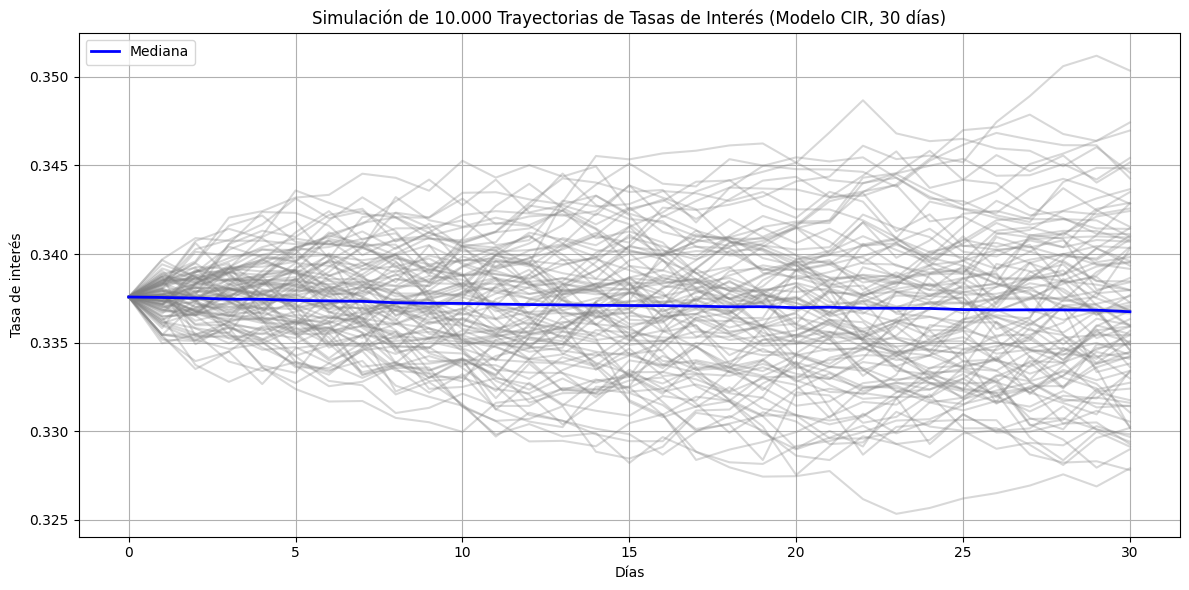

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(100):  # graficamos solo 100 trayectorias para claridad del grafico
    plt.plot(simulations[:, i], color='gray', alpha=0.3)

# Graficamos la mediana
mediana = np.median(simulations, axis=1)
plt.plot(mediana, color='blue', label='Mediana', linewidth=2)

plt.title('Simulación de 10.000 Trayectorias de Tasas de Interés (Modelo CIR, 30 días)')
plt.xlabel('Días')
plt.ylabel('Tasa de interés')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
